Computer Vision Final Project 2021
Submitted by: 
- Eliran Malka
- Itamar Yacoby
- Ben Lahav

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

In [2]:
def createMask(frame):
    
    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
       
    greenMask = cv2.inRange(hsv, greenLower, greenUpper)
    greenMask = cv2.erode(greenMask, None, iterations=1)
    greenMask = cv2.dilate(greenMask, None, iterations=1)


    blueMask = cv2.inRange(hsv, blueLower, blueUpper)
    blueMask = cv2.erode(blueMask, None, iterations=3)
    blueMask = cv2.dilate(blueMask, None, iterations=3)


    redMask = cv2.inRange(hsv, redLower, redUpper)
    redMask = cv2.erode(redMask, None, iterations=2)
    redMask = cv2.dilate(redMask, None, iterations=15)
    #cv2.imshow('redMask Juggling', redMask)    


      
    return greenMask,blueMask,redMask
    


In [3]:
def findBalls(frame):
    
    greenMask,blueMask,redMask = createMask(frame)
    
    cntsGreen = cv2.findContours(greenMask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    centerGreen = None

    cntsBlue = cv2.findContours(blueMask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    centerBlue = None

    cntsRed = cv2.findContours(redMask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    centerRed = None
    
    
    if len(cntsGreen) > 0:
        cGreen = max(cntsGreen, key=cv2.contourArea)
        ((x_green, y_green), radius_green) = cv2.minEnclosingCircle(cGreen)
        centerGreen = (int(x_green), int(y_green))
        
        frameGreen = frame.copy()
        if (radius_green < 15) & (radius_green > 10 ) : 
            cv2.circle(frameGreen,(int(x_green), int(y_green)), 12,(30, 255, 30), -1)
            cv2.circle(frameGreen, (int(x_green), int(y_green)), 14,(255, 255, 255), 2)            
            frame = cv2.addWeighted(frame, 0.3, frameGreen, 0.7, 0.0)


    if len(cntsBlue) > 0:   
        cBlue = max(cntsBlue, key=cv2.contourArea)
        ((x_blue, y_blue), radius_blue) = cv2.minEnclosingCircle(cBlue)
        centerBlue = (int(x_blue), int(y_blue))
        
        frameBlue = frame.copy()
        if (radius_blue < 14) & (radius_blue > 10 ) : 
            cv2.circle(frameBlue, (int(x_blue), int(y_blue)), 12,(255, 30, 30), -1)
            cv2.circle(frameBlue, (int(x_blue), int(y_blue)), 14,(255, 255, 255), 2)
            frame = cv2.addWeighted(frame, 0.3, frameBlue, 0.7, 0.0)

    if len(cntsRed)> 0 :
        cRed = max(cntsRed, key=cv2.contourArea)
        ((x_red, y_red), radius_red) = cv2.minEnclosingCircle(cRed)
        centerRed = (int(x_red), int(y_red))
        
        frameRed = frame.copy()
        if (radius_red < 40) & (radius_red > 8 ) : 
            # draw the circle and centroid on the frame,
            # then update the list of tracked points
            cv2.circle(frameRed, (int(x_red), int(y_red)), 12,(30, 30, 255), -1)
            cv2.circle(frameRed, (int(x_red), int(y_red)), 14,(255, 255, 255), 2)
            frame = cv2.addWeighted(frame, 0.3, frameRed, 0.7, 0.0)
            
            
    return frame,centerGreen,centerBlue,centerRed
    
    

In [4]:
def displayTrajectory(frame,ptsGreen,ptsBlue,ptsRed):
    frameTraj = frame.copy()
    for i in range(1, len(ptsRed)):
        # if either of the tracked points are None, ignore
        # them
        if ptsGreen[i] is None:
            continue
        # otherwise, compute the thickness of the line and
        # draw the connecting lines
        thickness = int(np.sqrt(100 / float(i + 1)) * 1.5)
        cv2.circle(frameTraj, ptsGreen[i], thickness,(0, 255, 0), -1)
        cv2.circle(frameTraj, ptsBlue[i], thickness,(255, 0, 0), -1)
        cv2.circle(frameTraj, ptsRed[i], thickness,(0, 0, 255), -1)
        #cv2.line(frameTraj, ptsGreen[i], ptsGreen[i], (0, 255, 0), thickness)
    frame = cv2.addWeighted(frame, 0.55, frameTraj, 0.45, 0.0)
        
    return frame

In [5]:
def calcDist(curr,prev):
    xDist = (curr[0]-prev[0])
    yDist = (curr[1]-prev[1])
    return (math.sqrt((xDist**2)+(yDist**2)))

In [6]:
def displayVelocity(frame,greenDist,blueDist,redDist,centerGreen,centerBlue,centerRed):
    frameVelocity = frame.copy()
      
    xGreen = (centerGreen[0])
    yGreen = (centerGreen[1])
    cv2.line(frameVelocity, (xGreen+14,yGreen), (xGreen+20, yGreen), (255, 255, 255), 2)     
    cv2.rectangle(frameVelocity, (xGreen+20, yGreen-15), (xGreen+60,yGreen+15), (255,255,255), -1)
    frame = cv2.addWeighted(frame, 0.55, frameVelocity, 0.45, 0.0)

        
    xBlue = (centerBlue[0])
    yBlue = (centerBlue[1])
    cv2.line(frameVelocity, (xBlue+14,yBlue), (xBlue+20, yBlue), (255, 255, 255), 2) 
    cv2.rectangle(frameVelocity, (xBlue+20, yBlue-15), (xBlue+60,yBlue+15), (255,255,255), -1)
    frame = cv2.addWeighted(frame, 0.55, frameVelocity, 0.45, 0.0)

    if (centerRed != None):    
        xRed = (centerRed[0])
        yRed = (centerRed[1])
    cv2.line(frameVelocity, (xRed+14,yRed), (xRed+20, yRed), (255, 255, 255), 2)    
    cv2.rectangle(frameVelocity, (xRed+20, yRed-15), (xRed+60,yRed+15), (255,255,255), -1)
    frame = cv2.addWeighted(frame, 0.55, frameVelocity, 0.45, 0.0)
        
        
    frame = cv2.putText(frame, str(int(blueDist)), (xGreen+32,yGreen+5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 1, cv2.LINE_AA)
    frame = cv2.putText(frame, str(int(greenDist)), (xBlue+32,yBlue+5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 1, cv2.LINE_AA)
    frame = cv2.putText(frame, str(int(redDist)), (xRed+32,yRed+5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 1, cv2.LINE_AA)

        
    return frame

1298


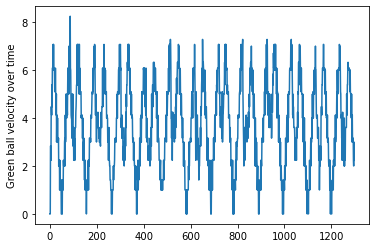

In [10]:
blueLower = (100, 50, 90)
blueUpper = (170, 255, 255) 

redLower = (1, 22, 240)
redUpper = (18, 240, 255)
    
greenLower = (30, 50, 50)
greenUpper = (80, 255, 255)

ptsGreen = list()
ptsBlue = list()
ptsRed = list()

greenListDist = [0,0,0]
blueListDist = [0,0,0]
redListDist = [0,0,0]

count = 0

cap = cv2.VideoCapture('P4_juggling.mov')
fps = cap.get(cv2.CAP_PROP_FPS)
# Get frame count
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) 
# Get width and height of video stream
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# Define the codec for output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# Set up output video
out = cv2.VideoWriter('video_out.mp4', fourcc, fps, (w, h))

while True:
    ret, frame = cap.read() # read next frame
    if ret==True:
        count+=1;
        
        frame = cv2.resize(frame,(640,360))
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        frame,centerGreen,centerBlue,centerRed = findBalls(frame)
        
        if (len(ptsGreen) > 20):
            ptsGreen.pop()
            ptsBlue.pop()
            ptsRed.pop()
            
            
        if (centerRed != None):
            ptsRed.insert(0,centerRed)
        ptsGreen.insert(0,centerGreen)
        ptsBlue.insert(0,centerBlue)
        
        
        frame = displayTrajectory(frame,ptsGreen,ptsBlue,ptsRed)
        
        
        if (count>3):
            greenListDist.append(calcDist(ptsGreen[0],ptsGreen[1]))
            blueListDist.append(calcDist(ptsBlue[0],ptsBlue[1]))
            redListDist.append(calcDist(ptsRed[0],ptsRed[1]))
        frame = displayVelocity(frame,greenListDist[-1],blueListDist[-1],redListDist[-1],ptsGreen[0],ptsBlue[0],ptsRed[0])
        
        cv2.imshow('Final Project Juggling', frame)    
        out.write(frame)
        if (cv2.waitKey(1) & 0xff == 27): # ESC key pressed?
            break
    else:
        break
        
        






        
print(count)
plt.plot(greenListDist)
plt.ylabel('Green ball velocity over time')
plt.show()
        
ptsGreen.clear()
ptsBlue.clear()
ptsRed.clear()
greenListDist.clear()
blueListDist.clear()
redListDist.clear()

out.release()
cap.release() # release input video
cv2.destroyAllWindows() # delete output window
cv2.waitKey(1);